In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import itertools
import sys
sys.path.append('..')
from security_game.target import Target
from security_game.green_security_game import GreenSecurityGame
from security_game.infra_security_game import InfraSecurityGame

from solvers.mip import mip
from solvers.nash import nash
from solvers.double_oracle import double_oracle
from solvers.double_oracle_sf import double_oracle_sf
from solvers.no_regret import regret_matching
import time
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

In [2]:
gdf = gpd.read_file("chinatown_infra.geojson")

# Step 1: Handle relevant columns
infra_columns = [
    "id", "name", "power", "man_made", "amenity",
    "generator:method", "generator:source", "geometry"
]
available_columns = [col for col in infra_columns if col in gdf.columns]
gdf = gdf[available_columns].copy()

# Step 2: Extract generator type if present
gdf["generator_type"] = gdf.get("generator:method")
if "generator_type" not in gdf.columns or gdf["generator_type"].isnull().all():
    gdf["generator_type"] = gdf.get("generator:source")

# Step 3: Construct unified 'type' column
gdf["type"] = gdf.get("power")
if "amenity" in gdf.columns:
    gdf["type"] = gdf["type"].combine_first(gdf["amenity"])
if "man_made" in gdf.columns:
    gdf["type"] = gdf["type"].combine_first(gdf["man_made"])

# Step 4: Refine generator classification (solar vs. other)
gdf.loc[(gdf["type"] == "generator") & (gdf["generator_type"] == "photovoltaic"), "type"] = "solar_generator"
gdf.loc[(gdf["type"] == "generator") & (gdf["generator_type"] == "solar"), "type"] = "solar_generator"

# Step 5: Drop raw columns now that 'type' is finalized
df_simple = gdf[["id", "name", "type", "geometry"]].copy()

# Step 6: Separate nodes and ways
df_nodes = df_simple[df_simple["id"].str.contains("node")].copy()
df_nodes["x"] = df_nodes.geometry.x
df_nodes["y"] = df_nodes.geometry.y
df_nodes = df_nodes.drop(columns=["geometry"])

df_ways = df_simple[df_simple["id"].str.contains("way")].copy()
df_ways = df_ways.set_geometry("geometry").to_crs("EPSG:32618")
df_ways["centroid"] = df_ways.geometry.centroid
df_ways = df_ways.set_geometry("centroid").to_crs("EPSG:4326")
df_ways["x"] = df_ways.geometry.x
df_ways["y"] = df_ways.geometry.y
df_ways = df_ways.drop(columns=["geometry", "centroid"])

# Step 7: Combine nodes and ways
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
ny_blocks_gdf =  gpd.read_file("tl_2020_36_tabblock20.shp")
INFRA_WEIGHTS = {
    # Power Infrastructure
    "plant": 1.5,
    "generator": 1.35,
    "solar_generator": 0.95,
    "substation": 1.45,
    "transformer": 1.25,
    "tower": 1.1,
    "pole": 0.85,
    "line": 1.0,
    "minor_line": 0.9,
    "cable": 0.95,
    "switchgear": 1.2,
    "busbar": 0.8,
    "bay": 0.85,
    "converter": 1.05,
    "insulator": 0.75,
    "portal": 0.75,
    "connection": 0.7,
    "compensator": 1.0,
    "rectifier": 0.95,
    "inverter": 0.95,
    "storage": 0.9,

    # Healthcare
    "hospital": 1.5,
    "clinic": 1.35,

    # Education
    "school": 1.25,
    "university": 1.4,

    # Water & Sanitation
    "water_works": 1.45,
    "wastewater_plant": 1.4,

    # Government & Emergency Services
    "fire_station": 1.3,
    "police": 1.4,
    "courthouse": 1.2,

    # Critical Infrastructure
    "bunker_silo": 1.0,

    # Communications
    "communications_tower": 1.25,
}


# GSG DO NFG (DONE)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

i=0
supports=[]
for num_timesteps in [7,8,9,10]:
    for num_attackers in [2,3]:
        for num_clusters in [7,8,9,10,11,12]:
            for dims in [7,8,9,10]:
                for dt in [1,2]:
                    for force_return in [True,False]:
                        gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims)
                        gsg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=False, force_return=force_return, general_sum=False, **schedule_form_kwargs)
                        D_a, D_d, u, c = double_oracle(gsg, dt, force_return, verbose=False)
                        support = sum([1 for p in D_d if p!=0])
                        supports.append(support)
                        print(f"{i}/767: timesteps:{num_timesteps}, num_attackers:{num_attackers}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, force_return:{force_return}, support:{support}")
                        i+=1

In [ ]:
sorted(supports, reverse=True)

In [ ]:
arr = np.array(supports)
ind = np.argpartition(arr, -13)[-13:]
ind[np.argsort(arr[ind])][::-1]

In [ ]:
#RESULTS WITH NO ADJUSTMENTS:
#400/767: timesteps:9, num_attackers:2, num_clusters:8, dims:7, dt:1, force_return:True, support:7
#659/767: timesteps:10, num_attackers:2, num_clusters:12, dims:7, dt:2, force_return:False, support:7
#755/767: timesteps:10, num_attackers:3, num_clusters:12, dims:7, dt:2, force_return:False, support:7
#752/767: timesteps:10, num_attackers:3, num_clusters:12, dims:7, dt:1, force_return:True, support:7
#549/767: timesteps:9, num_attackers:3, num_clusters:11, dims:8, dt:1, force_return:False, support:7

#609/767: timesteps:10, num_attackers:2, num_clusters:9, dims:7, dt:1, force_return:False, support:7 **
#417/767: timesteps:9, num_attackers:2, num_clusters:9, dims:7, dt:1, force_return:False, support:7 **

#705/767: timesteps:10, num_attackers:3, num_clusters:9, dims:7, dt:1, force_return:False, support:7 **
#513/767: timesteps:9, num_attackers:3, num_clusters:9, dims:7, dt:1, force_return:False, support:7 **

#721/767: timesteps:10, num_attackers:3, num_clusters:10, dims:7, dt:1, force_return:False, support:7 **
#529/767: timesteps:9, num_attackers:3, num_clusters:10, dims:7, dt:1, force_return:False, support:7 **

#625/767: timesteps:10, num_attackers:2, num_clusters:10, dims:7, dt:1, force_return:False, support:8 ***
#433/767: timesteps:9, num_attackers:2, num_clusters:10, dims:7, dt:1, force_return:False, support:7 ***
#THE REST
#241/767: timesteps:8, num_attackers:2, num_clusters:10, dims:7, dt:1, force_return:False, support:5
#49/767: timesteps:7, num_attackers:2, num_clusters:10, dims:7, dt:1, force_return:False, support:5
#11 is 9
#12 is 9


In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

num_timesteps_li = []
supports=[]
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []

for num_timesteps in [6,7,8,9,10,11,12,13,14,15]:
    print(num_timesteps)
    num_timesteps_li.append(num_timesteps)
    gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
    gsg.generate(num_attackers=2, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=False, defense_time_threshold=1, generate_actions=False, force_return=False, general_sum=False, **schedule_form_kwargs)
    D_a, D_d, u, A_a, A_d, c, its, gs = double_oracle(gsg, eps=1e-12, verbose=False)
    support = sum([1 for p in D_d if p!=0])
    supports.append(support)
    iterations_to_converge.append(c)
    iteration_times_li.append(its)
    gaps_li.append(gs)
    defender_actions_sizes.append(len(A_d))
    attacker_actions_sizes.append(len(A_a))

In [ ]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_times": iteration_times_li,
    "gaps": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["iteration_number"] = exploded_df.groupby("num_timesteps").cumcount()

# Reorder if desired
cols = ["num_timesteps", "iteration_number", "iteration_times", "gaps", 
        "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df.to_csv("GSG_NFG_DO.csv")

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
num_timesteps_li = []
supports=[]
num_attackers_li=[]
num_defenders_li=[]
num_clusters_li = []
dims_li = []
dts = []
frs = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10,11]:
    for num_attackers in [1,2,3]:
        for num_defenders in [1,2,3]:
            for num_clusters in [7,8,9,10,11,12]:
                for dims in [7,8,9,10]:
                    for dt in [1,2]:
                        for fr in [True, False]:
                            gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims)
                            gsg.generate(num_attackers=num_attackers, num_defenders=num_defenders, home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=False, defense_time_threshold=dt, generate_actions=False, force_return=fr, general_sum=False, **schedule_form_kwargs)
                            D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle(gsg,eps=1e-12, verbose=False)
                            support = sum([1 for p in D_d if p!=0])
                            supports.append(support)
                            num_timesteps_li.append(num_timesteps)
                            num_attackers_li.append(num_attackers)
                            num_defenders_li.append(num_defenders)
                            num_clusters_li.append(num_clusters)
                            dims_li.append(dims)
                            dts.append(dt)
                            frs.append(fr)
                            iterations_to_converge.append(c)
                            defender_actions_sizes.append(len(A_d))
                            attacker_actions_sizes.append(len(A_a))
                            iteration_times_li.append(iteration_times)
                            gaps_li.append(gaps)
                            print(f"{i}/4319: timesteps:{num_timesteps}, num_attackers:{num_attackers}, num_defenders:{num_defenders}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, fr:{fr}, support:{support}")
                            i+=1

In [ ]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "num_attackers": num_attackers_li,
    "num_defenders": num_defenders_li,
    "num_clusters": num_clusters_li,
    "dims": dims_li,
    "defense_time_threshold": dts,
    "force_return": frs,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_time": iteration_times_li,
    "gap": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_time", "gap"], ignore_index=True)

# Optional: Add a column for iteration number within each grouped trial
exploded_df["iteration_number"] = exploded_df.groupby(
    ["num_timesteps", "num_attackers", "num_defenders", "num_clusters", "dims", "force_return", "defense_time_threshold"]
).cumcount()

# Reorder if desired
cols = [
    "num_timesteps","num_attackers", "num_defenders", "num_clusters", "dims", "force_return", "defense_time_threshold",
    "iteration_number", "iteration_time", "gap", 
    "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"
]
exploded_df = exploded_df[cols]

# Make iteration number 1-indexed
exploded_df["iteration_number"] += 1
exploded_df

In [ ]:
exploded_df.to_csv("GSG_NFG_DO_MASS_FINAL.csv")

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
num_timesteps_li = []
supports=[]
num_clusters_li = []
dims_li = []
dts = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10,11]:
    for num_clusters in [7,8,9,10,11,12]:
        for dims in [7,8,9,10]:
            for dt in [1,2]:
                gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims)
                gsg.generate(num_attackers=1, num_defenders=3, home_base_assignments=[(kabo_djembe,), (bomassa,), (inner_post,)], num_timesteps=num_timesteps, generate_utility_matrix=False, defense_time_threshold=dt, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
                D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle(gsg,eps=1e-12, verbose=False)
                support = sum([1 for p in D_d if p!=0])
                supports.append(support)
                num_timesteps_li.append(num_timesteps)
                num_clusters_li.append(num_clusters)
                dims_li.append(dims)
                dts.append(dt)
                iterations_to_converge.append(c)
                defender_actions_sizes.append(len(A_d))
                attacker_actions_sizes.append(len(A_a))
                iteration_times_li.append(iteration_times)
                gaps_li.append(gaps)
                print(f"{i}/479: timesteps:{num_timesteps}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, support:{support}")
                i+=1

In [ ]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "num_clusters": num_clusters_li,
    "dims": dims_li,
    "defense_time_threshold": dts,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_time": iteration_times_li,
    "gap": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_time", "gap"], ignore_index=True)

# Optional: Add a column for iteration number within each grouped trial
exploded_df["iteration_number"] = exploded_df.groupby(
    ["num_timesteps", "num_clusters", "dims", "defense_time_threshold"]
).cumcount()

# Reorder if desired
cols = [
    "num_timesteps", "num_clusters", "dims", "defense_time_threshold",
    "iteration_number", "iteration_time", "gap", 
    "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"
]
exploded_df = exploded_df[cols]

# Make iteration number 1-indexed
exploded_df["iteration_number"] += 1
exploded_df

In [ ]:
exploded_df.to_csv("GSG_NFG_DO_3D_3_SEPARATE_HB.csv")

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
num_timesteps_li = []
supports=[]
num_clusters_li = []
dims_li = []
dts = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10,11,12,13,14,15]:
    for num_clusters in [7,8,9,10,11,12]:
        for dims in [7,8,9,10]:
            for dt in [1,2]:
                gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims)
                gsg.generate(num_attackers=1, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=False, defense_time_threshold=dt, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
                D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle(gsg,eps=1e-12, verbose=False)
                support = sum([1 for p in D_d if p!=0])
                supports.append(support)
                num_timesteps_li.append(num_timesteps)
                num_clusters_li.append(num_clusters)
                dims_li.append(dims)
                dts.append(dt)
                iterations_to_converge.append(c)
                defender_actions_sizes.append(len(A_d))
                attacker_actions_sizes.append(len(A_a))
                iteration_times_li.append(iteration_times)
                gaps_li.append(gaps)
                print(f"{i}/239: timesteps:{num_timesteps}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, support:{support}")
                i+=1

# GSG NR NFG

## RM

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

rm_num_attackers_li = []

rm_gaps_li = []
rm_interval_times_li = []
rm_num_timesteps_li = []
rm_frs = []
rm_dts = []

for num_timesteps in [7,8,9,10]:
    for num_attackers in [1,2,3]:
        for dt in [1,2]:
            for fr in [True,False]:
                gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
                gsg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=dt, generate_actions=False, force_return=fr, general_sum=False, **schedule_form_kwargs)
                D_d, U, gaps, interval_times = regret_matching(gsg.utility_matrix, runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=False, predictive=False, verbose=True)
                rm_num_attackers_li.append(num_attackers)
                rm_frs.append(fr)
                rm_dts.append(dt)
                rm_gaps_li.append(gaps)
                rm_interval_times_li.append(interval_times)
                rm_num_timesteps_li.append(num_timesteps)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": rm_num_timesteps_li,
    "num_attackers": rm_num_attackers_li,
    "num_defenders": [1 for i in range(len(rm_num_timesteps_li))],
    "defense_time_threshold": rm_dts,
    "force_return": rm_frs,
    "iteration_times": rm_interval_times_li,
    "gaps": rm_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_attackers","force_return","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "force_return", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("GSG_NFG_RM_FINAL_WITH_FR_DT.csv")

## RM+

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

rmp_num_attackers_li = []

rmp_gaps_li = []
rmp_interval_times_li = []
rmp_num_timesteps_li = []
rmp_frs = []
rmp_dts = []
for num_timesteps in [7,8,9,10]:
    for num_attackers in [1,2,3]:
        for dt in [1,2]:
            for fr in [True,False]:
                gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
                gsg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=dt, generate_actions=False, force_return=fr, general_sum=False, **schedule_form_kwargs)
                D_d, U, gaps, interval_times = regret_matching(gsg.utility_matrix, runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=True, predictive=False, verbose=True)
                rmp_num_attackers_li.append(num_attackers)
                rmp_frs.append(fr)
                rmp_dts.append(dt)
                rmp_gaps_li.append(gaps)
                rmp_interval_times_li.append(interval_times)
                rmp_num_timesteps_li.append(num_timesteps)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": rmp_num_timesteps_li,
    "num_attackers": rmp_num_attackers_li,
    "num_defenders": [1 for i in range(len(rmp_num_timesteps_li))],
    "defense_time_threshold": rmp_dts,
    "force_return": rmp_frs,
    "iteration_times": rmp_interval_times_li,
    "gaps": rmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_attackers", "force_return","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "force_return", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("GSG_NFG_RMP_FINAL_WITH_FR_DT.csv")

## PRM+ (DONE)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

prmp_num_attackers_li = []

prmp_gaps_li = []
prmp_interval_times_li = []
prmp_num_timesteps_li = []
prmp_frs = []
prmp_dts = []

for num_timesteps in [7,8,9,10]:
    for num_attackers in [1,2,3]:
        for dt in [1,2]:
            for fr in [True,False]:
                gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
                gsg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=dt, generate_actions=False, force_return=fr, general_sum=False, **schedule_form_kwargs)
                D_d, U, gaps, interval_times = regret_matching(gsg.utility_matrix, runtime=120, interval=5, iterations=10000, averaging=2, alternations=True, plus=True, predictive=True, verbose=True)
                prmp_num_attackers_li.append(num_attackers)
                prmp_frs.append(fr)
                prmp_dts.append(dt)
                prmp_gaps_li.append(gaps)
                prmp_interval_times_li.append(interval_times)
                prmp_num_timesteps_li.append(num_timesteps)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": prmp_num_timesteps_li,
    "num_attackers": prmp_num_attackers_li,
    "num_defenders": [1 for i in range(len(prmp_num_timesteps_li))],
    "defense_time_threshold": prmp_dts,
    "force_return": prmp_frs,
    "iteration_times": prmp_interval_times_li,
    "gaps": prmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_attackers", "force_return","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "force_return", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("GSG_NFG_PRMP_FINAL_WITH_FR_DT.csv")

# GSG DO SF (DONE)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5, #from real source
    "defender_penalty_factor": 5,
    "extra_coverage_weight":0.1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
gsg.generate(num_attackers=2, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=7, generate_utility_matrix=True, defense_time_threshold=1, generate_actions=False, force_return=False, general_sum=False, **schedule_form_kwargs)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 100,
    "defender_penalty_factor": 100,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

num_timesteps_li = []
supports=[]
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []

for num_timesteps in [6,7,8,9,10]:
    print(num_timesteps)
    num_timesteps_li.append(num_timesteps)
    gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
    gsg.generate(num_attackers=2, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=False, defense_time_threshold=1, generate_actions=False, force_return=False, general_sum=False, **schedule_form_kwargs)
    D_a, D_d, u, A_a, A_d, c, its, gs = double_oracle_sf(gsg.schedule_form_dict, eps=1e-12, verbose=False)
    support = sum([1 for p in D_d if p!=0])
    supports.append(support)
    iterations_to_converge.append(c)
    iteration_times_li.append(its)
    gaps_li.append(gs)
    defender_actions_sizes.append(len(A_d))
    attacker_actions_sizes.append(len(A_a))

In [ ]:
supports

In [ ]:
gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
gsg.generate(num_attackers=2, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=10, generate_utility_matrix=False, defense_time_threshold=1, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
D_a, D_d, u, A_a, A_d, c, its, gs = double_oracle_sf(gsg.schedule_form_dict, eps=1e-12, verbose=False)

In [ ]:
gsg.draw_graph()

In [2]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
num_timesteps_li = []
num_defenders_li = []
supports=[]
num_clusters_li = []
dims_li = []
dts = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for num_clusters in [7,8,9,10,11,12]:
            for dims in [7,8,9,10]:
                for dt in [1,2]:
                    gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims)
                    gsg.generate(num_attackers=1, 
                                 num_defenders=num_defenders, 
                                 home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], 
                                 num_timesteps=num_timesteps, 
                                 generate_utility_matrix=False, 
                                 defense_time_threshold=dt, 
                                 generate_actions=True, 
                                 force_return=True, 
                                 general_sum=False, 
                                 **schedule_form_kwargs)
                    D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle_sf(gsg.schedule_form_dict,eps=1e-12, verbose=False)
                    support = sum([1 for p in D_d if p!=0])
                    supports.append(support)
                    num_timesteps_li.append(num_timesteps)
                    num_defenders_li.append(num_defenders)
                    num_clusters_li.append(num_clusters)
                    dims_li.append(dims)
                    dts.append(dt)
                    iterations_to_converge.append(c)
                    defender_actions_sizes.append(len(A_d))
                    attacker_actions_sizes.append(len(A_a))
                    iteration_times_li.append(iteration_times)
                    gaps_li.append(gaps)
                    print(f"{i}/575: timesteps:{num_timesteps}, num_defenders:{num_defenders}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, support:{support}")
                    i+=1

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2455389
Academic license 2455389 - for non-commercial use only - registered to jc___@columbia.edu
0/575: timesteps:7, num_defenders:1, num_clusters:7, dims:7, dt:1, support:2
1/575: timesteps:7, num_defenders:1, num_clusters:7, dims:7, dt:2, support:2
2/575: timesteps:7, num_defenders:1, num_clusters:7, dims:8, dt:1, support:2
3/575: timesteps:7, num_defenders:1, num_clusters:7, dims:8, dt:2, support:1
4/575: timesteps:7, num_defenders:1, num_clusters:7, dims:9, dt:1, support:2
5/575: timesteps:7, num_defenders:1, num_clusters:7, dims:9, dt:2, support:1
6/575: timesteps:7, num_defenders:1, num_clusters:7, dims:10, dt:1, support:2
7/575: timesteps:7, num_defenders:1, num_clusters:7, dims:10, dt:2, support:1
8/575: timesteps:7, num_defenders:1, num_clusters:8, dims:7, dt:1, support:2
9/575: timesteps:7, num_defenders:1, num_clusters:8, dims:7, dt:2, support:2
10/575: timesteps:7, num_defenders:1, num_clust

In [3]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "num_defenders": num_defenders_li,
    "num_clusters": num_clusters_li,
    "dims": dims_li,
    "defense_time_threshold": dts,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_time": iteration_times_li,
    "gap": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_time", "gap"], ignore_index=True)

# Optional: Add a column for iteration number within each grouped trial
exploded_df["iteration_number"] = exploded_df.groupby(
    ["num_timesteps", "num_defenders", "num_clusters", "dims", "defense_time_threshold"]
).cumcount()

# Reorder if desired
cols = [
    "num_timesteps", "num_defenders", "num_clusters", "dims", "defense_time_threshold",
    "iteration_number", "iteration_time", "gap", 
    "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"
]
exploded_df = exploded_df[cols]

# Make iteration number 1-indexed
exploded_df["iteration_number"] += 1

exploded_df

,num_timesteps,num_defenders,num_clusters,dims,defense_time_threshold,iteration_number,iteration_time,gap,iterations_to_converge,def_support,defender_actions_size,attacker_actions_size
0,7,1,7,7,1,1,0.012764,0.806915,5,2,3,3
1,7,1,7,7,1,2,0.0,0.8,5,2,3,3
2,7,1,7,7,1,3,0.001,0.587234,5,2,3,3
3,7,1,7,7,1,4,0.001,0.629787,5,2,3,3
4,7,1,7,7,1,5,0.001,0.0,5,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
7809,10,3,12,10,2,29,0.013013,0.095917,33,7,31,9
7810,10,3,12,10,2,30,0.025408,0.12954,33,7,31,9
7811,10,3,12,10,2,31,0.016651,0.029117,33,7,31,9
7812,10,3,12,10,2,32,0.015821,0.103894,33,7,31,9


In [4]:
exploded_df.to_csv("GSG_SF_DO_MASS_FINAL.csv")

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
num_timesteps_li = []
supports=[]
num_clusters_li = []
dims_li = []
dts = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10]:
    for num_clusters in [7,8,9,10,11,12]:
        for dims in [7,8,9,10]:
            for dt in [1,2]:
                gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims)
                gsg.generate(num_attackers=1, num_defenders=3, home_base_assignments=[(kabo_djembe,), (bomassa,), (inner_post,)], num_timesteps=num_timesteps, generate_utility_matrix=False, defense_time_threshold=dt, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
                D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle_sf(gsg.schedule_form_dict,eps=1e-12, verbose=False)
                support = sum([1 for p in D_d if p!=0])
                supports.append(support)
                num_timesteps_li.append(num_timesteps)
                num_clusters_li.append(num_clusters)
                dims_li.append(dims)
                dts.append(dt)
                iterations_to_converge.append(c)
                defender_actions_sizes.append(len(A_d))
                attacker_actions_sizes.append(len(A_a))
                iteration_times_li.append(iteration_times)
                gaps_li.append(gaps)
                print(f"{i}/191: timesteps:{num_timesteps}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, support:{support}")
                i+=1

In [ ]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "num_clusters": num_clusters_li,
    "dims": dims_li,
    "defense_time_threshold": dts,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_time": iteration_times_li,
    "gap": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_time", "gap"], ignore_index=True)

# Optional: Add a column for iteration number within each grouped trial
exploded_df["iteration_number"] = exploded_df.groupby(
    ["num_timesteps", "num_clusters", "dims", "defense_time_threshold"]
).cumcount()

# Reorder if desired
cols = [
    "num_timesteps", "num_clusters", "dims", "defense_time_threshold",
    "iteration_number", "iteration_time", "gap", 
    "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"
]
exploded_df = exploded_df[cols]

# Make iteration number 1-indexed
exploded_df["iteration_number"] += 1

exploded_df

In [ ]:
exploded_df.to_csv("GSG_SF_DO_3D_3_SEPARATE_HB.csv")

# GSG NR SF

### Not iterating over dims and clusters in order to save time

## RM (DONE)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

srm_num_defenders_li = []
srm_dts = []

srm_gaps_li = []
srm_interval_times_li = []
srm_num_timesteps_li = []

for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
            gsg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=dt, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(gsg.schedule_form_dict["defender_utility_matrix"], runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=False, predictive=False, verbose=True)
            srm_num_defenders_li.append(num_defenders)
            srm_dts.append(dt)
            srm_gaps_li.append(gaps)
            srm_interval_times_li.append(interval_times)
            srm_num_timesteps_li.append(num_timesteps)


In [ ]:
df = pd.DataFrame({
    "num_timesteps": srm_num_timesteps_li,
    "num_attackers": [1 for i in range(len(srm_num_timesteps_li))],
    "num_defenders": srm_num_defenders_li,
    "defense_time_threshold": srm_dts,
    "iteration_times": srm_interval_times_li,
    "gaps": srm_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_defenders","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("GSG_SF_RM_FINAL_FIXED.csv")

## RM+

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

rmp_gaps_li = []
rmp_interval_times_li = []
rmp_num_timesteps_li = []

for num_timesteps in [6,7,8,9,10]:
    gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
    gsg.generate(num_attackers=2, num_defenders=1, home_base_assignments=[(kabo_djembe, bomassa, inner_post)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=1, generate_actions=False, force_return=False, general_sum=False, **schedule_form_kwargs)
    D_d, U, gaps, interval_times = regret_matching(gsg.utility_matrix, runtime=120, interval=10, iterations=100000, averaging=0, alternations=False, plus=True, predictive=False, verbose=True)
    rmp_gaps_li.append(gaps)
    rmp_interval_times_li.append(interval_times)
    rmp_num_timesteps_li.append(num_timesteps)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

srmp_num_defenders_li = []
srmp_dts = []

srmp_gaps_li = []
srmp_interval_times_li = []
srmp_num_timesteps_li = []

for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
            gsg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=dt, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(gsg.schedule_form_dict["defender_utility_matrix"], runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=True, predictive=False, verbose=True)
            srmp_num_defenders_li.append(num_defenders)
            srmp_dts.append(dt)
            srmp_gaps_li.append(gaps)
            srmp_interval_times_li.append(interval_times)
            srmp_num_timesteps_li.append(num_timesteps)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": srmp_num_timesteps_li,
    "num_attackers": [1 for i in range(len(srmp_num_timesteps_li))],
    "num_defenders": srmp_num_defenders_li,
    "defense_time_threshold": srmp_dts,
    "iteration_times": srmp_interval_times_li,
    "gaps": srmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_defenders","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("GSG_SF_RMP_FINAL_FIXED.csv")

## PRM+ (DONE)

In [ ]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)

sprmp_num_defenders_li = []
sprmp_dts = []

sprmp_gaps_li = []
sprmp_interval_times_li = []
sprmp_num_timesteps_li = []

for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=10, num_rows=7, num_columns=7)
            gsg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, defense_time_threshold=dt, generate_actions=False, force_return=True, general_sum=False, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(gsg.schedule_form_dict["defender_utility_matrix"], runtime=120, interval=5, iterations=10000, averaging=2, alternations=True, plus=True, predictive=True, verbose=True)
            sprmp_num_defenders_li.append(num_defenders)
            sprmp_dts.append(dt)
            sprmp_gaps_li.append(gaps)
            sprmp_interval_times_li.append(interval_times)
            sprmp_num_timesteps_li.append(num_timesteps)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": sprmp_num_timesteps_li,
    "num_attackers": [1 for i in range(len(sprmp_num_timesteps_li))],
    "num_defenders": sprmp_num_defenders_li,
    "defense_time_threshold": sprmp_dts,
    "iteration_times": sprmp_interval_times_li,
    "gaps": sprmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_defenders","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("GSG_SF_PRMP_FINAL_FIXED.csv")

# ISG DO NFG

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

num_timesteps_li = []
num_attackers_li = []
num_defenders_li = []
supports=[]
dims_li = []
dts = []
frs = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10,11]:
    for num_attackers in [1,2,3]:
        for num_defenders in [1,2,3]:
            for dt in [1,2]:
                for fr in [True, False]:
                    isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
                    isg.generate(num_attackers=num_attackers, num_defenders=num_defenders, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=False, generate_actions=False, normalize=True, force_return=fr, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
                    D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle(isg,eps=1e-12, verbose=False)
                    support = sum([1 for p in D_d if p!=0])
                    supports.append(support)
                    num_timesteps_li.append(num_timesteps)
                    num_attackers_li.append(num_attackers)
                    num_defenders_li.append(num_defenders)
                    dts.append(dt)
                    frs.append(fr)
                    iterations_to_converge.append(c)
                    defender_actions_sizes.append(len(A_d))
                    attacker_actions_sizes.append(len(A_a))
                    iteration_times_li.append(iteration_times)
                    gaps_li.append(gaps)
                    print(f"{i}/179: timesteps:{num_timesteps}, num_attackers:{num_attackers}, num_defenders:{num_defenders}, dt:{dt}, fr:{fr}, support:{support}")
                    i+=1

In [ ]:
isg.draw_graph()

In [ ]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "num_attackers": num_attackers_li,
    "num_defenders": num_defenders_li,
    "defense_time_threshold": dts,
    "force_return": frs,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_time": iteration_times_li,
    "gap": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_time", "gap"], ignore_index=True)

# Optional: Add a column for iteration number within each grouped trial
exploded_df["iteration_number"] = exploded_df.groupby(
    ["num_timesteps", "num_attackers", "num_defenders", "force_return", "defense_time_threshold"]
).cumcount()

# Reorder if desired
cols = [
    "num_timesteps","num_attackers", "num_defenders", "force_return", "defense_time_threshold",
    "iteration_number", "iteration_time", "gap", 
    "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"
]
exploded_df = exploded_df[cols]

# Make iteration number 1-indexed
exploded_df["iteration_number"] += 1
exploded_df

In [ ]:
exploded_df.to_csv("ISG_NFG_DO_MASS_FINAL.csv")

# ISG RM NFG

## RM

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

rm_num_timesteps_li = []
rm_num_attackers_li= []
rm_gaps_li = []
rm_interval_times_li = []
rm_dts = []

start=time.time()
for num_timesteps in [7,8,9,10]:
    for num_attackers in [1,2,3]:
        for dt in [1,2]:
            print(f"starting {num_timesteps} timesteps, {num_attackers} attackers, {dt} dt. Time since start: {time.time()-start}")
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=False, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(isg.utility_matrix, runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=False, predictive=False, verbose=False)
            rm_num_timesteps_li.append(num_timesteps)
            rm_num_attackers_li.append(num_attackers)
            rm_dts.append(dt)
            rm_gaps_li.append(gaps)
            rm_interval_times_li.append(interval_times)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": rm_num_timesteps_li,
    "num_attackers": rm_num_attackers_li,
    "num_defenders": [1 for i in range(len(rm_num_timesteps_li))],
    "defense_time_threshold": rm_dts,
    "iteration_times": rm_interval_times_li,
    "gaps": rm_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_attackers","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("ISG_NFG_RM_FINAL.csv")

## RM+

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

rmp_num_timesteps_li = []
rmp_num_attackers_li= []
rmp_gaps_li = []
rmp_interval_times_li = []
rmp_dts = []

start=time.time()
for num_timesteps in [7,8,9,10]:
    for num_attackers in [1,2,3]:
        for dt in [1,2]:
            print(f"starting {num_timesteps} timesteps, {num_attackers} attackers, {dt} dt. Time since start: {time.time()-start}")
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=False, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(isg.utility_matrix, runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=True, predictive=False, verbose=False)
            rmp_num_timesteps_li.append(num_timesteps)
            rmp_num_attackers_li.append(num_attackers)
            rmp_dts.append(dt)
            rmp_gaps_li.append(gaps)
            rmp_interval_times_li.append(interval_times)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": rmp_num_timesteps_li,
    "num_attackers": rmp_num_attackers_li,
    "num_defenders": [1 for i in range(len(rmp_num_timesteps_li))],
    "defense_time_threshold": rmp_dts,
    "iteration_times": rmp_interval_times_li,
    "gaps": rmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_attackers","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("ISG_NFG_RMP_FINAL.csv")

## PRM+

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": False,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":0.9
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

prmp_num_timesteps_li = []
prmp_num_attackers_li= []
prmp_gaps_li = []
prmp_interval_times_li = []
prmp_dts = []

start=time.time()
for num_timesteps in [7,8,9]:
    for num_attackers in [1,2,3]:
        for dt in [1,2]:
            print(f"starting {num_timesteps} timesteps, {num_attackers} attackers, {dt} dt. Time since start: {time.time()-start}")
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=num_attackers, num_defenders=1, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=False, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(isg.utility_matrix, runtime=120, interval=5, iterations=10000, averaging=2, alternations=True, plus=True, predictive=True, verbose=False)
            prmp_num_timesteps_li.append(num_timesteps)
            prmp_num_attackers_li.append(num_attackers)
            prmp_dts.append(dt)
            prmp_gaps_li.append(gaps)
            prmp_interval_times_li.append(interval_times)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": prmp_num_timesteps_li,
    "num_attackers": prmp_num_attackers_li,
    "num_defenders": [1 for i in range(len(prmp_num_timesteps_li))],
    "defense_time_threshold": prmp_dts,
    "iteration_times": prmp_interval_times_li,
    "gaps": prmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_attackers"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("ISG_NFG_PRMP_FINAL.csv")

# ISG DO SF

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":1.0
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

num_timesteps_li = []
num_defenders_li = []
supports=[]
dts = []
defender_actions_sizes = []
attacker_actions_sizes = []
iterations_to_converge = []
iteration_times_li = []
gaps_li = []
i=0
for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=True, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_a, D_d, u, A_a, A_d, c, iteration_times, gaps = double_oracle_sf(isg.schedule_form_dict,eps=1e-12, verbose=False)
            support = sum([1 for p in D_d if p!=0])
            supports.append(support)
            num_timesteps_li.append(num_timesteps)
            num_defenders_li.append(num_defenders)
            dts.append(dt)
            iterations_to_converge.append(c)
            defender_actions_sizes.append(len(A_d))
            attacker_actions_sizes.append(len(A_a))
            iteration_times_li.append(iteration_times)
            gaps_li.append(gaps)
            print(f"{i}/23: timesteps:{num_timesteps}, num_defenders:{num_defenders}, dt:{dt}, support:{support}")
            i+=1

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2455389
Academic license 2455389 - for non-commercial use only - registered to jc___@columbia.edu
0/23: timesteps:7, num_defenders:1, dt:1, support:3
1/23: timesteps:7, num_defenders:1, dt:2, support:1


KeyboardInterrupt: 

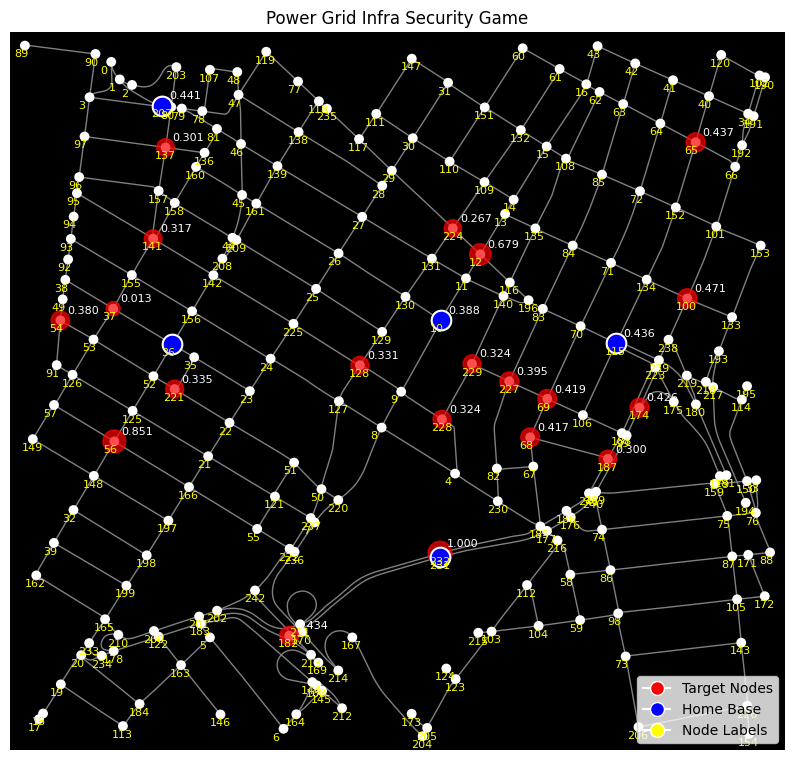

In [5]:
isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
isg.generate(num_attackers=1, num_defenders=1, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza)], num_timesteps=7, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=True, defense_time_threshold=2, **general_sum_kwargs, **schedule_form_kwargs)
isg.draw_graph()

In [ ]:
df = pd.DataFrame({
    "num_timesteps": num_timesteps_li,
    "num_defenders": num_defenders_li,
    "defense_time_threshold": dts,
    "def_support": supports,
    "iterations_to_converge": iterations_to_converge,
    "iteration_time": iteration_times_li,
    "gap": gaps_li,
    "defender_actions_size": defender_actions_sizes,
    "attacker_actions_size": attacker_actions_sizes
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_time", "gap"], ignore_index=True)

# Optional: Add a column for iteration number within each grouped trial
exploded_df["iteration_number"] = exploded_df.groupby(
    ["num_timesteps", "num_defenders", "defense_time_threshold"]
).cumcount()

# Reorder if desired
cols = [
    "num_timesteps", "num_defenders", "defense_time_threshold",
    "iteration_number", "iteration_time", "gap", 
    "iterations_to_converge", "def_support", "defender_actions_size", "attacker_actions_size"
]
exploded_df = exploded_df[cols]

# Make iteration number 1-indexed
exploded_df["iteration_number"] += 1

exploded_df

In [ ]:
exploded_df.to_csv("GSG_SF_DO_MASS_FINAL.csv")

# ISG RM SF

## RM

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

srm_num_timesteps_li = []
srm_num_defenders_li= []
srm_gaps_li = []
srm_interval_times_li = []
srm_dts = []

start = time.time()
for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            print(f"starting {num_timesteps} timesteps, {num_defenders} defenders, {dt} dt. Time since start: {time.time()-start}")
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=False, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(isg.schedule_form_dict["defender_utility_matrix"], runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=False, predictive=False, verbose=False)
            srm_num_timesteps_li.append(num_timesteps)
            srm_num_defenders_li.append(num_defenders)
            srm_dts.append(dt)
            srm_gaps_li.append(gaps)
            srm_interval_times_li.append(interval_times)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": srm_num_timesteps_li,
    "num_attackers": [1 for i in range(len(srm_num_timesteps_li))],
    "num_defenders": srm_num_defenders_li,
    "defense_time_threshold": srm_dts,
    "iteration_times": srm_interval_times_li,
    "gaps": srm_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_defenders","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("ISG_SF_RM_FINAL.csv")

## RM+

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

srmp_num_timesteps_li = []
srmp_num_defenders_li= []
srmp_gaps_li = []
srmp_interval_times_li = []
srmp_dts = []

start = time.time()
for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            print(f"starting {num_timesteps} timesteps, {num_defenders} defenders, {dt} dt. Time since start: {time.time()-start}")
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=False, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(isg.schedule_form_dict["defender_utility_matrix"], runtime=120, interval=5, iterations=10000, averaging=0, alternations=False, plus=True, predictive=False, verbose=False)
            srmp_num_timesteps_li.append(num_timesteps)
            srmp_num_defenders_li.append(num_defenders)
            srmp_dts.append(dt)
            srmp_gaps_li.append(gaps)
            srmp_interval_times_li.append(interval_times)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": srmp_num_timesteps_li,
    "num_attackers": [1 for i in range(len(srmp_num_timesteps_li))],
    "num_defenders": srmp_num_defenders_li,
    "defense_time_threshold": srmp_dts,
    "iteration_times": srmp_interval_times_li,
    "gaps": srmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_defenders","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("ISG_SF_RMP_FINAL.csv")

## PRM+

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3,
    "extra_coverage_weight":1
}

general_sum_kwargs = {
    "general_sum": False,
    "attacker_feature_value":  42, 
    "defender_feature_value": 69, 
    "defender_step_cost": 32.5, 
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

sprmp_num_timesteps_li = []
sprmp_num_defenders_li= []
sprmp_gaps_li = []
sprmp_interval_times_li = []
sprmp_dts = []

start = time.time()
for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            print(f"starting {num_timesteps} timesteps, {num_defenders} defenders, {dt} dt. Time since start: {time.time()-start}")
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=1, num_defenders=num_defenders, home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], num_timesteps=num_timesteps, generate_utility_matrix=True, generate_actions=False, normalize=True, force_return=False, defense_time_threshold=dt, **general_sum_kwargs, **schedule_form_kwargs)
            D_d, U, gaps, interval_times = regret_matching(isg.schedule_form_dict["defender_utility_matrix"], runtime=120, interval=5, iterations=10000, averaging=2, alternations=True, plus=True, predictive=True, verbose=False)
            sprmp_num_timesteps_li.append(num_timesteps)
            sprmp_num_defenders_li.append(num_defenders)
            sprmp_dts.append(dt)
            sprmp_gaps_li.append(gaps)
            sprmp_interval_times_li.append(interval_times)

In [ ]:
df = pd.DataFrame({
    "num_timesteps": sprmp_num_timesteps_li,
    "num_attackers": [1 for i in range(len(sprmp_num_timesteps_li))],
    "num_defenders": sprmp_num_defenders_li,
    "defense_time_threshold": sprmp_dts,
    "iteration_times": sprmp_interval_times_li,
    "gaps": sprmp_gaps_li
})

# Step 2: Explode list columns
exploded_df = df.explode(["iteration_times", "gaps"], ignore_index=True)

# Optional: Add a column for iteration number within each trial
exploded_df["interval_number"] = exploded_df.groupby(["num_timesteps","num_defenders","defense_time_threshold"]).cumcount()

# Reorder if desired
cols = ["num_timesteps", "num_attackers", "num_defenders", "defense_time_threshold", "interval_number", "iteration_times", "gaps"]
exploded_df = exploded_df[cols]

exploded_df

In [ ]:
exploded_df["interval_number"] = exploded_df["interval_number"]+1
exploded_df["iteration_number"] = exploded_df["interval_number"]*5

In [ ]:
exploded_df

In [ ]:
exploded_df.to_csv("ISG_SF_PRMP_FINAL.csv")